<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Attempt_at_a_Hysteresis_Loop_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

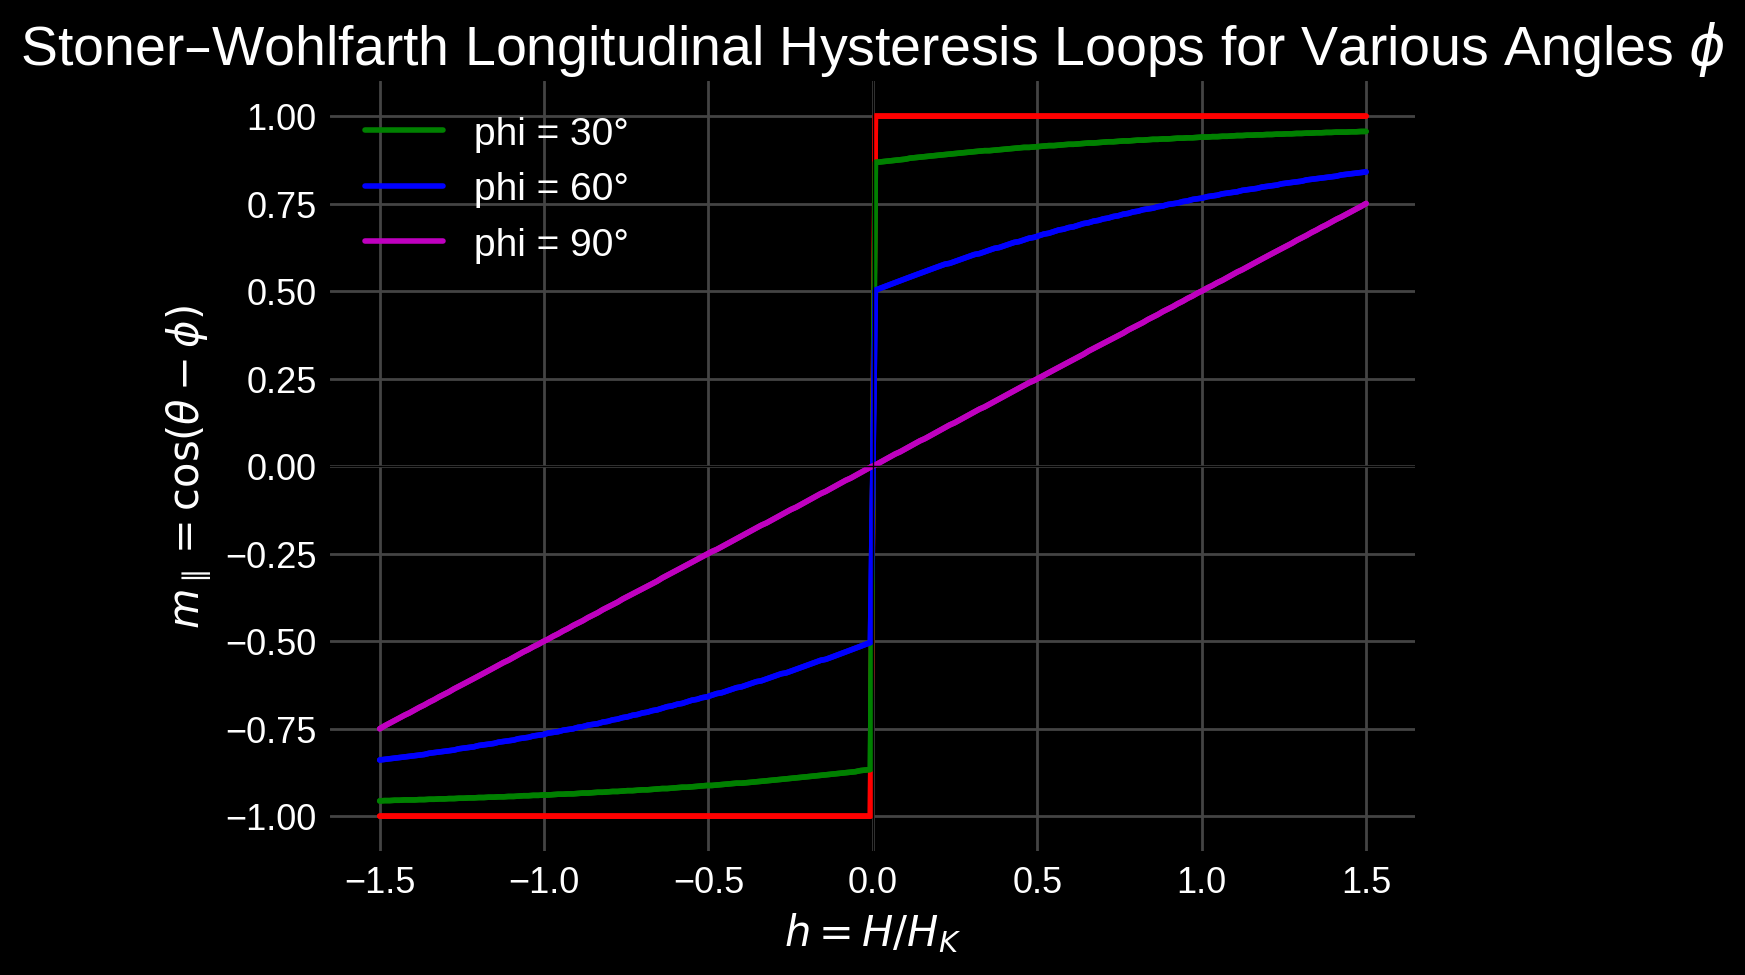

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Onri prefers using rcParams to increase the quality of all plots to be higher than the default settings.
# This only needs to be done once at beginning of every Jupyter Notebook.
plt.rcParams['figure.dpi'] = 200

# High contrast plotting style via rcParams
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.facecolor'] = '#000000'
plt.rcParams['axes.facecolor'] = '#000000'
plt.rcParams['axes.edgecolor'] = '#FFFFFF'
plt.rcParams['axes.labelcolor'] = '#FFFFFF'
plt.rcParams['xtick.color'] = '#FFFFFF'
plt.rcParams['ytick.color'] = '#FFFFFF'
plt.rcParams['text.color'] = '#FFFFFF'
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['grid.color'] = '#444444'

def stoner_wohlfarth_energy(theta, h, phi):
    """
    Returns the normalized Stoner-Wohlfarth energy:
      E = sin^2(theta) - h cos(theta - phi).
    Angles theta, phi in radians.
    h = H/HK (dimensionless).
    """
    return np.sin(theta)**2 - h * np.cos(theta - phi)

def find_minimum_energy_theta(h, phi, theta_guess_array):
    """
    Given a field h, angle phi, and a dense array of trial angles,
    find the angle (or angles) that minimize E(theta).
    Returns the (theta_min, E_min).
    """
    energies = stoner_wohlfarth_energy(theta_guess_array, h, phi)
    idx_min = np.argmin(energies)
    return theta_guess_array[idx_min], energies[idx_min]

def compute_sw_loop(phi_deg, n_points=200, n_angles=2000):
    """
    Compute the Stoner-Wohlfarth longitudinal hysteresis loop
    for a given angle phi (in degrees).
    Returns two arrays (h_arr, m_parr) for the ascending branch and
    (h_arr, m_parr) for the descending branch.
    """
    # Convert phi to radians
    phi = np.radians(phi_deg)

    # Field range (e.g. from -1.5 to +1.5 times HK)
    hmax = 1.5
    h_arr_asc = np.linspace(-hmax, +hmax, n_points)  # ascending
    h_arr_desc = np.linspace(+hmax, -hmax, n_points) # descending

    # A dense grid of angles to search for minima
    theta_grid = np.linspace(0, 2*np.pi, n_angles)

    # -- Ascending branch --
    # Start from a large negative H and guess that the magnetization is ~ -EA
    # We'll track the stable theta as we move forward in H.
    m_asc = []
    theta_prev, _ = find_minimum_energy_theta(h_arr_asc[0], phi, theta_grid)

    for h_val in h_arr_asc:
        # Search near the previous solution to pick the correct branch
        # For a simple approach, we just do a discrete search again:
        theta_sol, e_sol = find_minimum_energy_theta(h_val, phi, theta_grid)

        # Store this solution
        m_asc.append(np.cos(theta_sol - phi))
        theta_prev = theta_sol

    # -- Descending branch --
    m_desc = []
    theta_prev, _ = find_minimum_energy_theta(h_arr_desc[0], phi, theta_grid)

    for h_val in h_arr_desc:
        theta_sol, e_sol = find_minimum_energy_theta(h_val, phi, theta_grid)
        m_desc.append(np.cos(theta_sol - phi))
        theta_prev = theta_sol

    return (h_arr_asc, np.array(m_asc)), (h_arr_desc, np.array(m_desc))

# ---- MAIN: generate loops for various phi and plot ----
phi_list = [0, 30, 60, 90]
colors = ['r', 'g', 'b', 'm']
plt.figure(figsize=(7,5))

for phi_deg, c in zip(phi_list, colors):
    (h_asc, m_asc), (h_desc, m_desc) = compute_sw_loop(phi_deg)

    # Plot ascending
    plt.plot(h_asc, m_asc, color=c, label=f"phi = {phi_deg}°" if phi_deg!=0 else None)
    # Plot descending
    plt.plot(h_desc, m_desc, color=c)

plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel(r'$h = H/H_K$')
plt.ylabel(r'$m_{\parallel} = \cos(\theta - \phi)$')
plt.title('Stoner–Wohlfarth Longitudinal Hysteresis Loops for Various Angles $\phi$')
plt.legend(loc='best')
plt.grid(True)
plt.show()


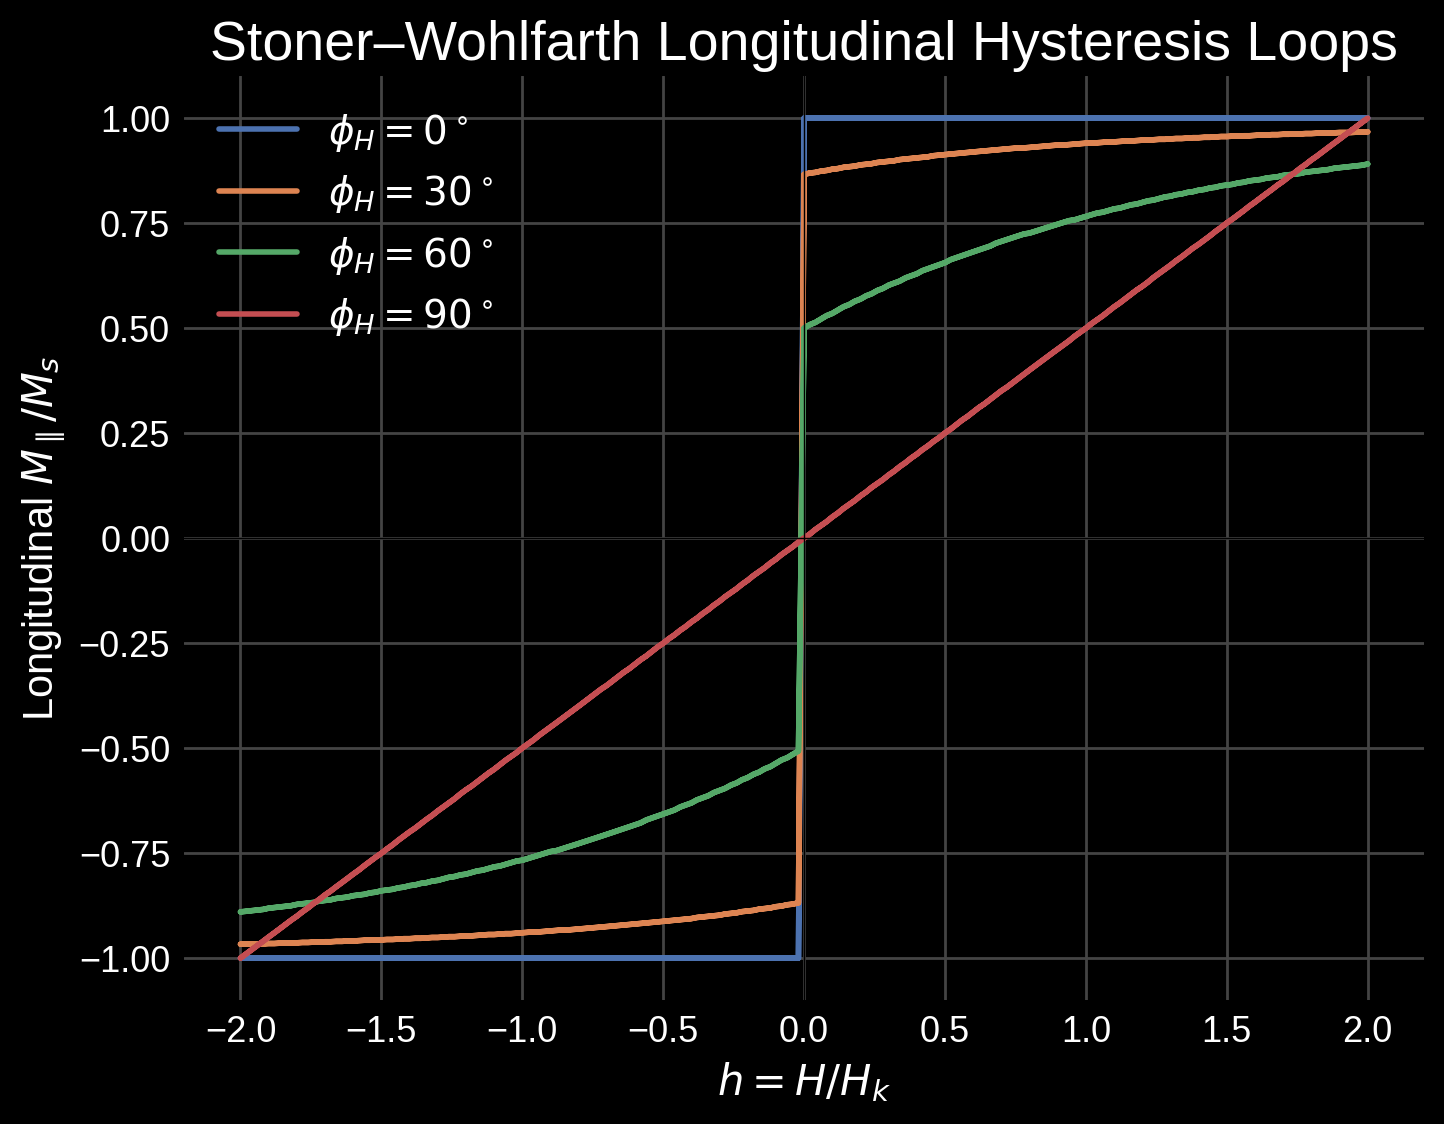

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def energy(theta, h, phi):
    """
    Dimensionless Stoner–Wohlfarth energy:
        E ~ sin^2(theta) - h cos(theta - phi)
    """
    return np.sin(theta)**2 - h * np.cos(theta - phi)

def find_local_minimum(theta_grid, h, phi, theta_prev=None):
    """
    Given a grid of theta values (0 to 2π), returns the theta at which the
    energy is minimal. If theta_prev is provided, we favor the local min
    nearest theta_prev to preserve continuity in a hysteresis sweep.
    """
    E_vals = energy(theta_grid, h, phi)
    i_min = np.argmin(E_vals)
    theta_min = theta_grid[i_min]

    # If no previous angle is given, just return the global minimum:
    if theta_prev is None:
        return theta_min

    # Otherwise, we also check if there's another local minima
    # near theta_prev. We'll do a simple local search:
    # 1) Start from the global min
    # 2) Also check small neighborhoods around it
    #    (In a finer approach, you'd do a local minimization or check multiple minima.)

    # For simplicity, we just pick the global min or the best candidate near theta_prev
    # in this discrete grid.  A more refined approach can be used as needed.
    diff = np.abs(theta_grid - theta_prev)
    i_near = np.argmin(diff)

    # local candidate
    i_candidates = [i_min, i_near]
    best_theta = None
    best_E = None

    for i_cand in i_candidates:
        E_cand = E_vals[i_cand]
        if best_E is None or E_cand < best_E:
            best_E = E_cand
            best_theta = theta_grid[i_cand]

    return best_theta

def hysteresis_sweep(h_values, phi, n_theta=2000):
    """
    Perform a hysteresis sweep for the field values given in h_values,
    returning arrays of (h_values, cos(theta - phi)) for each step.
    """
    theta_grid = np.linspace(0, 2*np.pi, n_theta)

    # We will store the magnetization projection M|| / Ms = cos(theta - phi)
    m_parallel = np.zeros_like(h_values)

    # We'll start from the global minimum for the first h
    theta_solution = find_local_minimum(theta_grid, h_values[0], phi, theta_prev=None)
    m_parallel[0] = np.cos(theta_solution - phi)

    # Now proceed through the rest of h_values, picking the local minimum
    for i in range(1, len(h_values)):
        theta_solution = find_local_minimum(theta_grid, h_values[i], phi,
                                            theta_prev=theta_solution)
        m_parallel[i] = np.cos(theta_solution - phi)

    return m_parallel

# Main script: define angles, define a range of h, do a forward and backward sweep
angles_deg = [0, 30, 60, 90]
phi_list = [np.deg2rad(a) for a in angles_deg]

# Range of dimensionless fields h, going from -2.0 to +2.0 and back
h_forward = np.linspace(-2.0, 2.0, 201)
h_backward = np.linspace(2.0, -2.0, 201)
h_loop = np.concatenate((h_forward, h_backward))

plt.figure(figsize=(8,6))

for phi, angle in zip(phi_list, angles_deg):
    # Sweep from negative to positive
    m_for = hysteresis_sweep(h_forward, phi)
    # Sweep back from positive to negative
    m_back = hysteresis_sweep(h_backward, phi)

    # Combine the forward and backward parts
    m_loop = np.concatenate((m_for, m_back))

    # Plot the loop
    plt.plot(h_loop, m_loop, label=f'$\phi_H = {angle}^\circ$')

plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.title('Stoner–Wohlfarth Longitudinal Hysteresis Loops')
plt.xlabel(r'$h = H / H_{k}$')
plt.ylabel(r'Longitudinal $M_\parallel / M_s$')
plt.legend(loc='best')
plt.grid(True)
plt.show()


<ipython-input-54-a5b0ae3bd5f7>:38: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]
<ipython-input-54-a5b0ae3bd5f7>:38: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]


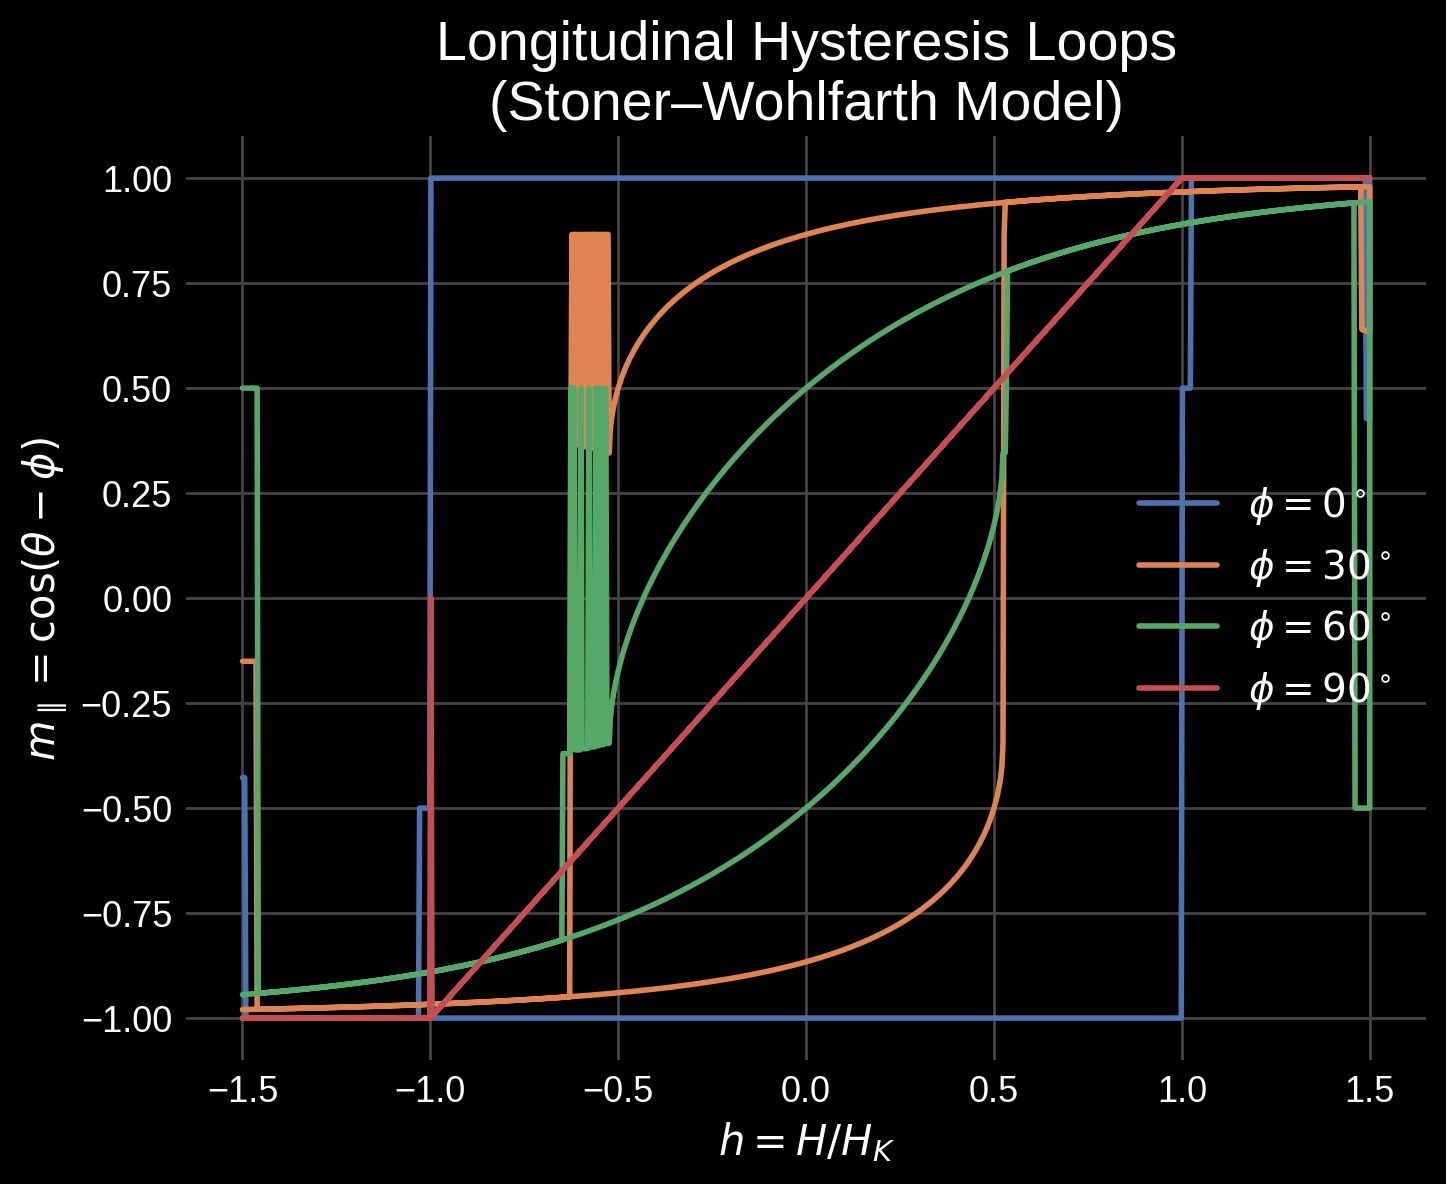

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# ===============================================================
# 1. Define the SW equations and stability checks
# ===============================================================

def f(theta, h, phi):
    """
    The condition dE/dtheta = 0 for the dimensionless SW energy:
    E = 0.5*sin^2(theta) - h*cos(theta - phi).
    Then dE/dtheta = sin(theta)*cos(theta) + h*sin(theta - phi).
    """
    return np.sin(theta)*np.cos(theta) + h*np.sin(theta - phi)

def energy(theta, h, phi):
    """
    Dimensionless energy (up to a constant):
    E = 0.5*sin^2(theta) - h*cos(theta - phi)
    """
    return 0.5*np.sin(theta)**2 - h*np.cos(theta - phi)

def d2E(theta, h, phi):
    """
    Second derivative of the energy:
    d^2E/dtheta^2 = cos(2*theta) + h*cos(theta - phi).
    """
    return np.cos(2*theta) + h*np.cos(theta - phi)

def solve_theta(h, phi, theta_guess):
    """
    Solve dE/dtheta = 0 using fsolve near theta_guess.
    If the solution is unstable (d2E < 0), then scan over [0, pi]
    to find a stable local minimum near theta_guess.
    """
    # 1. Use fsolve from the guess:
    theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]

    # 2. Check stability. If d2E < 0, do a quick fallback scan:
    if d2E(theta_sol, h, phi) < 0:
        thetas = np.linspace(0, np.pi, 1000)
        E_vals = energy(thetas, h, phi)
        d2E_vals = np.cos(2*thetas) + h*np.cos(thetas - phi)

        # Only consider stable points with d2E >= 0
        stable_mask = (d2E_vals >= 0)
        if np.any(stable_mask):
            stable_thetas = thetas[stable_mask]
            stable_Evals = E_vals[stable_mask]

            # Among the stable points, pick the one closest to theta_guess
            idx = np.argmin(np.abs(stable_thetas - theta_guess))
            theta_sol = stable_thetas[idx]

    return theta_sol

# ===============================================================
# 2. Hysteresis sweeps (forward and backward)
# ===============================================================

def get_branch(phi, h_values, theta_initial):
    """
    Generate a branch of the hysteresis loop (forward or backward)
    by continuously solving for theta, using each previous solution
    as the next guess.
    """
    thetas = []
    theta_current = theta_initial
    for h in h_values:
        theta_current = solve_theta(h, phi, theta_current)
        thetas.append(theta_current)
    return np.array(thetas)


# ===============================================================
# 3. Main script for angles 0°, 30°, 60°, 90°
# ===============================================================

# Define a range of normalized fields (H/H_k) with enough resolution to get smooth curves
h_min, h_max = -1.5, 1.5
n_points = 1000
h_forward = np.linspace(h_min, h_max, n_points)   # increasing field
h_backward = h_forward[::-1]                      # decreasing field

# Angles for which we want the loops (in degrees)
phi_degrees = [0, 30, 60, 90]

plt.figure(figsize=(8,6))

for phi_deg in phi_degrees:
    phi = np.radians(phi_deg)

    # Forward sweep: start from theta ~ 0 at large negative field
    # (meaning magnetization is ~ aligned along the "easy" direction for negative H)
    theta_init_for = 0.0
    theta_for = get_branch(phi, h_forward, theta_init_for)
    m_for = np.cos(theta_for - phi)

    # Backward sweep: start from theta ~ pi at large positive field
    # (meaning magnetization is reversed)
    theta_init_back = np.pi
    theta_back = get_branch(phi, h_backward, theta_init_back)
    m_back = np.cos(theta_back - phi)

    # Combine the two sweeps
    h_total = np.concatenate((h_forward, h_backward))
    m_total = np.concatenate((m_for, m_back))

    plt.plot(h_total, m_total, label=f"$\\phi={phi_deg}^\\circ$")

plt.xlabel(r"$h = H/H_K$")
plt.ylabel(r"$m_\parallel = \cos(\theta - \phi)$")
plt.title("Longitudinal Hysteresis Loops\n(Stoner–Wohlfarth Model)")
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-55-c9be348c6eff>:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]
<ipython-input-55-c9be348c6eff>:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]


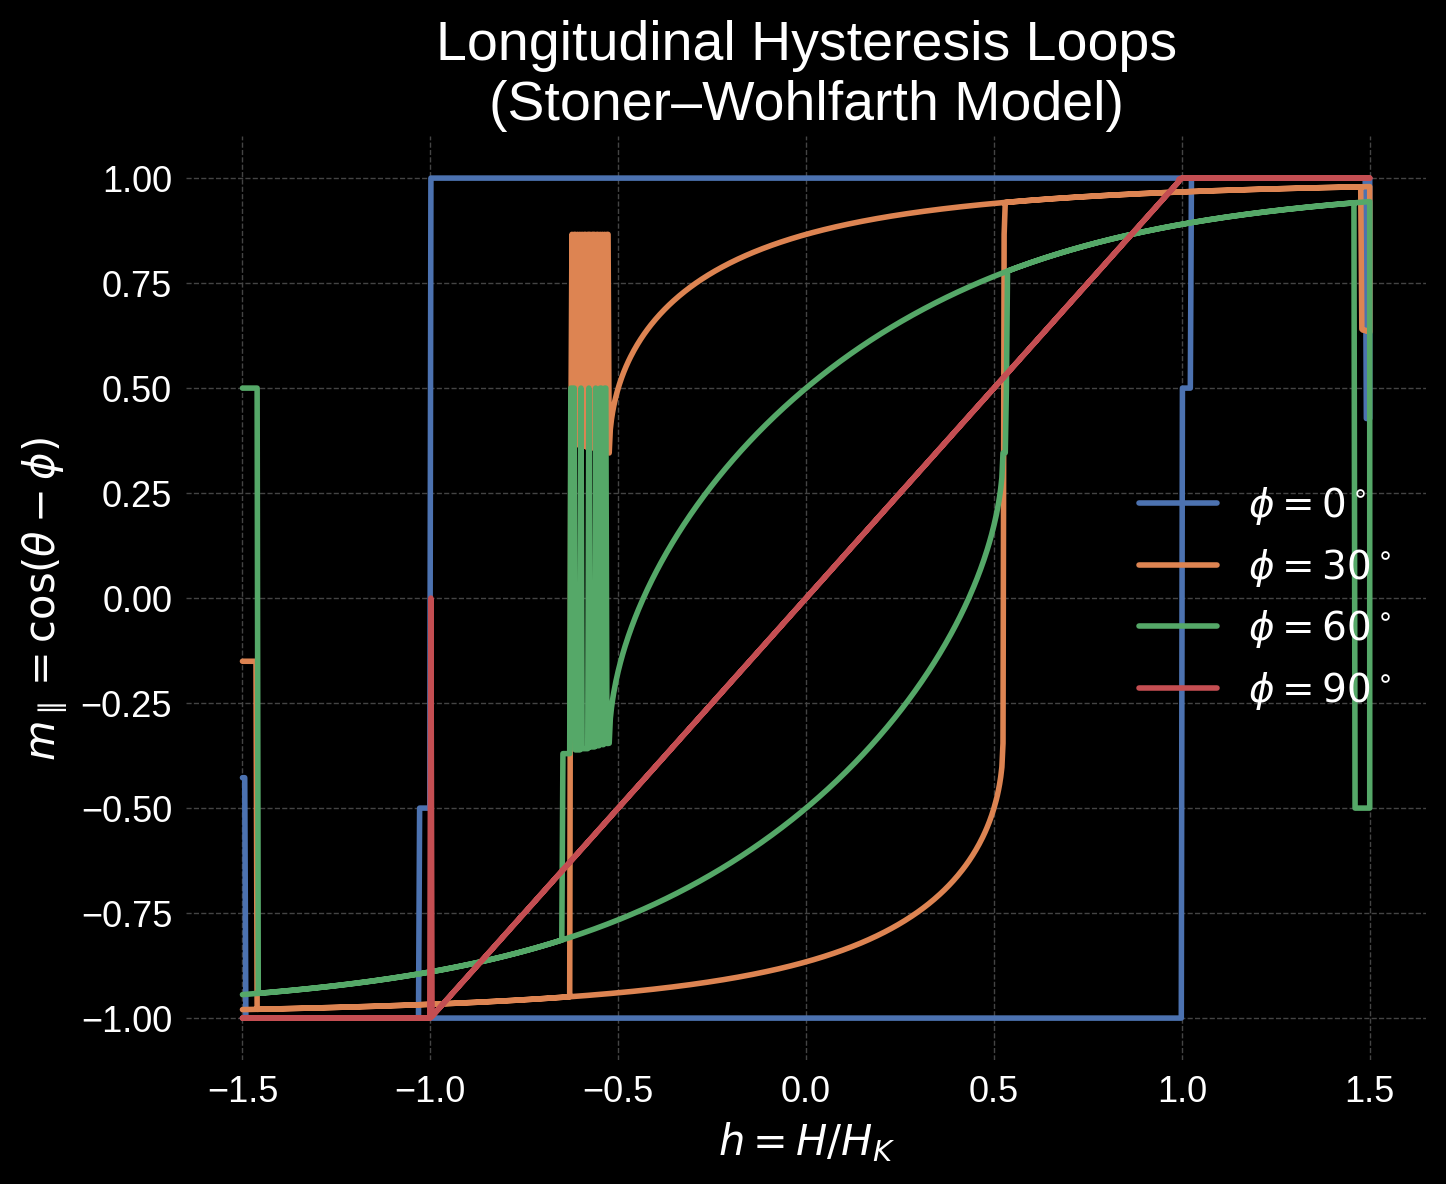

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# ===============================================================
# 1. Define SW model equations
# ===============================================================

def f(theta, h, phi):
    """ Condition dE/dtheta = 0 for energy minimization. """
    return np.sin(theta) * np.cos(theta) + h * np.sin(theta - phi)

def energy(theta, h, phi):
    """ Dimensionless energy function. """
    return 0.5 * np.sin(theta)**2 - h * np.cos(theta - phi)

def d2E(theta, h, phi):
    """ Second derivative for stability check. """
    return np.cos(2 * theta) + h * np.cos(theta - phi)

def solve_theta(h, phi, theta_guess):
    """ Solve dE/dtheta = 0 and ensure stability (d²E/dθ² ≥ 0). """
    theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]

    if d2E(theta_sol, h, phi) < 0:  # If unstable, scan for a stable minimum
        thetas = np.linspace(0, np.pi, 1000)
        stable_thetas = thetas[d2E(thetas, h, phi) >= 0]
        if len(stable_thetas) > 0:
            theta_sol = stable_thetas[np.argmin(np.abs(stable_thetas - theta_guess))]

    return theta_sol

# ===============================================================
# 2. Compute hysteresis branches
# ===============================================================

def compute_hysteresis(phi, h_values, theta_initial):
    """ Compute forward or backward branch of the hysteresis loop. """
    thetas = [theta_initial]
    for h in h_values:
        thetas.append(solve_theta(h, phi, thetas[-1]))
    return np.array(thetas[1:])  # Remove initial guess

# ===============================================================
# 3. Plot Hysteresis Loops
# ===============================================================

h_values = np.linspace(-1.5, 1.5, 1000)  # Normalized field range
phi_degrees = [0, 30, 60, 90]  # Angles to simulate

plt.figure(figsize=(8,6))

for phi_deg in phi_degrees:
    phi = np.radians(phi_deg)

    # Forward and backward sweeps
    theta_for = compute_hysteresis(phi, h_values, theta_initial=0.0)
    theta_back = compute_hysteresis(phi, h_values[::-1], theta_initial=np.pi)

    # Compute magnetization projections
    m_total = np.concatenate((np.cos(theta_for - phi), np.cos(theta_back - phi)))
    h_total = np.concatenate((h_values, h_values[::-1]))

    plt.plot(h_total, m_total, label=f"$\\phi={phi_deg}^\\circ$")

plt.xlabel(r"$h = H/H_K$")
plt.ylabel(r"$m_\parallel = \cos(\theta - \phi)$")
plt.title("Longitudinal Hysteresis Loops\n(Stoner–Wohlfarth Model)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.show()


<ipython-input-56-06e7cedd81ba>:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]
<ipython-input-56-06e7cedd81ba>:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]


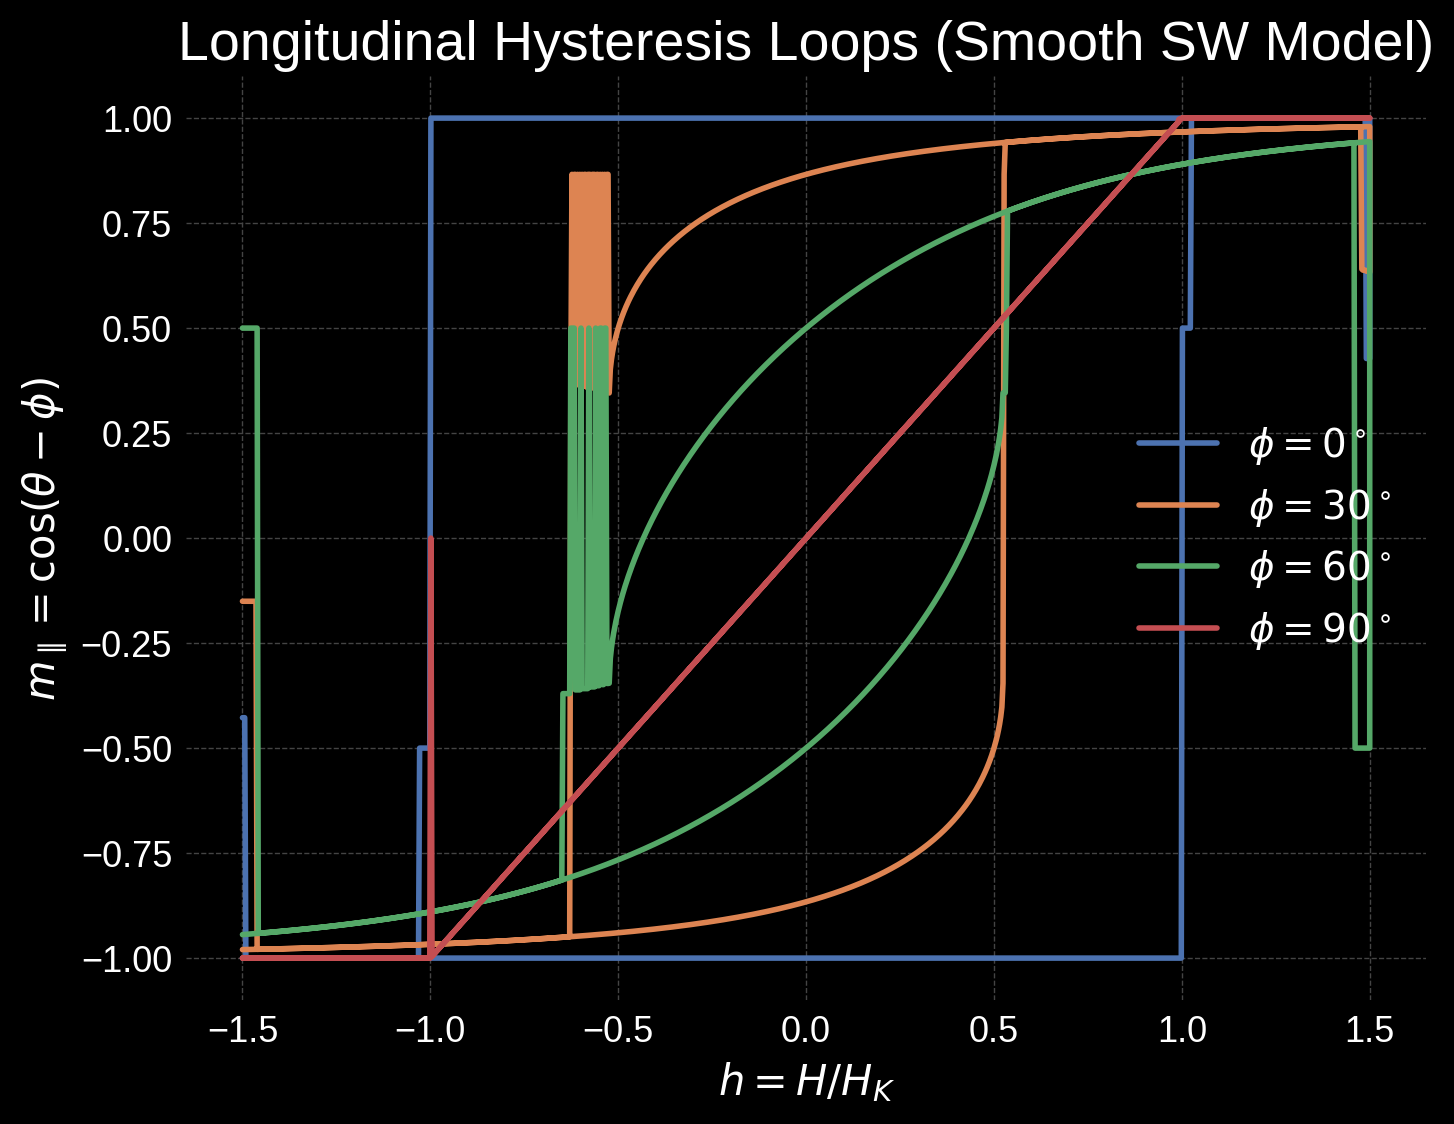

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# ===============================================================
# 1. Define SW model equations
# ===============================================================

def f(theta, h, phi):
    """ Condition dE/dtheta = 0 for energy minimization. """
    return np.sin(theta) * np.cos(theta) + h * np.sin(theta - phi)

def energy(theta, h, phi):
    """ Dimensionless energy function. """
    return 0.5 * np.sin(theta)**2 - h * np.cos(theta - phi)

def d2E(theta, h, phi):
    """ Second derivative for stability check. """
    return np.cos(2 * theta) + h * np.cos(theta - phi)

def solve_theta(h, phi, theta_guess, prev_theta=None):
    """ Solve dE/dtheta = 0 and ensure stability with smooth selection. """
    theta_sol = fsolve(lambda th: f(th, h, phi), theta_guess)[0]

    if d2E(theta_sol, h, phi) < 0:  # If unstable, scan for a stable minimum
        thetas = np.linspace(0, np.pi, 1000)
        stable_thetas = thetas[d2E(thetas, h, phi) >= 0]
        if len(stable_thetas) > 0:
            # Smoothly select the nearest stable solution to prevent sharp jumps
            if prev_theta is not None:
                theta_sol = stable_thetas[np.argmin(np.abs(stable_thetas - prev_theta))]
            else:
                theta_sol = stable_thetas[np.argmin(np.abs(stable_thetas - theta_guess))]

    return theta_sol

# ===============================================================
# 2. Compute hysteresis branches with smooth transitions
# ===============================================================

def compute_hysteresis(phi, h_values, theta_initial):
    """ Compute forward or backward branch with smooth selection. """
    thetas = [theta_initial]
    for h in h_values:
        theta_next = solve_theta(h, phi, thetas[-1], prev_theta=thetas[-1])
        thetas.append(theta_next)

    return np.array(thetas[1:])  # Remove initial guess

# ===============================================================
# 3. Plot Hysteresis Loops
# ===============================================================

h_values = np.linspace(-1.5, 1.5, 1000)  # Normalized field range
phi_degrees = [0, 30, 60, 90]  # Angles to simulate

plt.figure(figsize=(8,6))

for phi_deg in phi_degrees:
    phi = np.radians(phi_deg)

    # Forward and backward sweeps with smooth transitions
    theta_for = compute_hysteresis(phi, h_values, theta_initial=0.0)
    theta_back = compute_hysteresis(phi, h_values[::-1], theta_initial=np.pi)

    # Compute magnetization projections
    m_total = np.concatenate((np.cos(theta_for - phi), np.cos(theta_back - phi)))
    h_total = np.concatenate((h_values, h_values[::-1]))

    plt.plot(h_total, m_total, label=f"$\\phi={phi_deg}^\\circ$")

plt.xlabel(r"$h = H/H_K$")
plt.ylabel(r"$m_\parallel = \cos(\theta - \phi)$")
plt.title("Longitudinal Hysteresis Loops (Smooth SW Model)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.show()
